<a href="https://colab.research.google.com/github/Kalze1/statistical-modelling-of-time-series-data-detecting/blob/Understanding-the-Model-and-Data/notebook/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install arch
!pip install statsmodels
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install wbdata


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.vector_ar.var_model import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the data
file_path = '/content/drive/My Drive/Brent Oil Price Analysis/data/BrentOilPrices.csv'
df = pd.read_csv(file_path)

# Convert the Date column to datetime, allowing pandas to infer the format
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
# df.set_index('Date', inplace=True)

# Display first few rows
df.head()


<ipython-input-21-49bc911c8182>:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
<ipython-input-21-49bc911c8182>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [22]:
# Check for missing values
df.isnull().sum()


,0
Date,0
Price,0


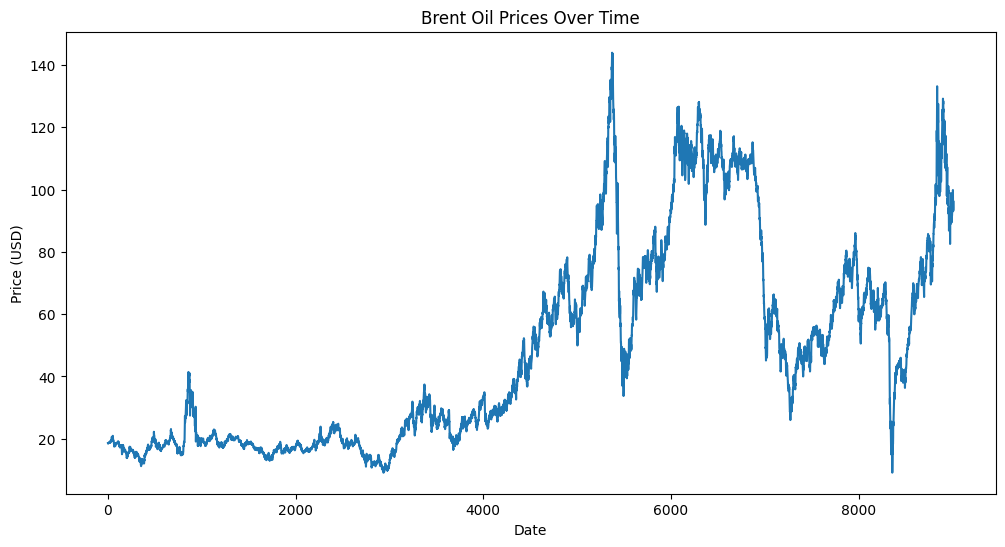

In [23]:
# Plot the oil prices over time
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()


In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price_Scaled'] = scaler.fit_transform(df[['Price']])


In [24]:
result = adfuller(df['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


In [26]:
arima_model = ARIMA(df['Price'], order=(1, 1, 1)).fit()  # Adjust (p, d, q) as needed
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Tue, 05 Nov 2024   AIC                          29093.899
Time:                        06:12:17   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

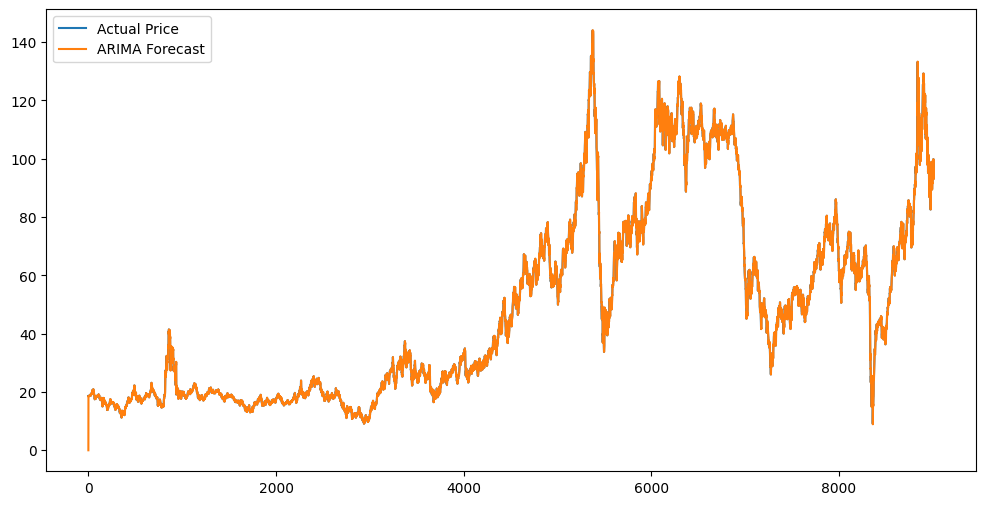

In [27]:
df['ARIMA_Forecast'] = arima_model.predict(start=0, end=len(df)-1)
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Actual Price')
plt.plot(df['ARIMA_Forecast'], label='ARIMA Forecast')
plt.legend()
plt.show()


In [28]:
garch_model = arch_model(df['Price'], vol='Garch', p=1, q=1).fit()
print(garch_model.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 3874927804.158277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 70148.68734205695
Iteration:      3,   Func. Count:     19,   Neg. LLF: 924509187.1107914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 44099.26204018903
Iteration:      5,   Func. Count:     33,   Neg. LLF: 41882.581755042986
Iteration:      6,   Func. Count:     39,   Neg. LLF: 41190.23335963133
Iteration:      7,   Func. Count:     46,   Neg. LLF: 40221.97253756566
Iteration:      8,   Func. Count:     52,   Neg. LLF: 38675.84139852016
Iteration:      9,   Func. Count:     58,   Neg. LLF: 46507.19984815386
Iteration:     10,   Func. Count:     64,   Neg. LLF: 52311.49939565074
Iteration:     11,   Func. Count:     73,   Neg. LLF: 39566.28900289833
Iteration:     12,   Func. Count:     79,   Neg. LLF: 37683.04414723057
Iteration:     13,   Func. Count:     85,   Neg. LLF: 38550.85348090723
Iteration:     14,   Func. Count:     91,   Neg. LLF: 48052.343

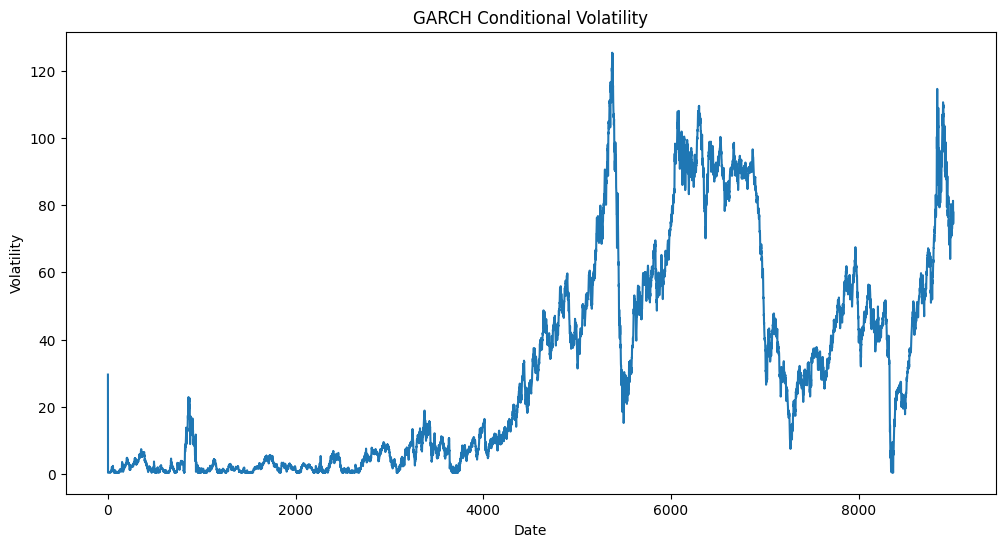

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(garch_model.conditional_volatility)
plt.title('GARCH Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()


In [30]:
import yfinance as yf

# Get historical data
data = yf.download("CL=F", start="2010-01-01", end="2023-12-31")

[*********************100%***********************]  1 of 1 completed


In [31]:
import wbdata
import pandas as pd
from datetime import datetime

# Define indicators for GDP, inflation, unemployment, and exchange rate
indicators = {
    'NY.GDP.MKTP.CD': 'GDP',             # GDP (current US$)
    'FP.CPI.TOTL.ZG': 'Inflation',       # Inflation, consumer prices (annual %)
    'SL.UEM.TOTL.ZS': 'Unemployment',    # Unemployment, total (% of total labor force)
    'PA.NUS.FCRF': 'ExchangeRate'        # Official exchange rate (LCU per US$, period average)
}

# Fetch data from World Bank for all available dates
data = wbdata.get_dataframe(indicators, country='WLD', freq='M')

# Filter by date range (from 1987-05-20 to 2022-11-14)
start_date = '1987-05-20'
end_date = '2022-11-14'
data = data[(data.index >= start_date) & (data.index <= end_date)]

# Reset index to prepare for merging and save to CSV
data.reset_index(inplace=True)
data.rename(columns={'date': 'Date'}, inplace=True)

# Save the data to Google Drive
file_path = '/content/drive/My Drive/Brent Oil Price Analysis/data/economic_indicators_data.csv'
data.to_csv(file_path, index=False)

# Display first few rows to confirm
data.head()


,Date,GDP,Inflation,Unemployment,ExchangeRate
0,2022,1.012251e+14,7.967574,5.264616,None
1,2021,9.752703e+13,3.466926,6.033761,None
2,2020,8.557772e+13,1.920968,6.585288,None
3,2019,8.794557e+13,2.206073,5.582980,None
4,2018,8.668687e+13,2.450362,5.756398,None


In [32]:
economic_indicators = pd.read_csv('/content/drive/My Drive/Brent Oil Price Analysis/data/world_inflation_data.csv', parse_dates=True)
df_combined = pd.concat([df['Price'], economic_indicators], axis=1).dropna()


In [33]:
model = VAR(df_combined)
var_model = model.fit()
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Nov, 2024
Time:                     06:12:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -57.6271
Nobs:                     35.0000    HQIC:                  -57.9763
Log likelihood:           880.818    FPE:                5.52824e-26
AIC:                     -58.1604    Det(Omega_mle):     3.99574e-26
--------------------------------------------------------------------
Results for equation Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               29.306330        10.899329            2.689           0.007
L1.Price             0.682538         0.147824            4.617           0.000
L1.date             -0.011596         0.004238           -2.736 

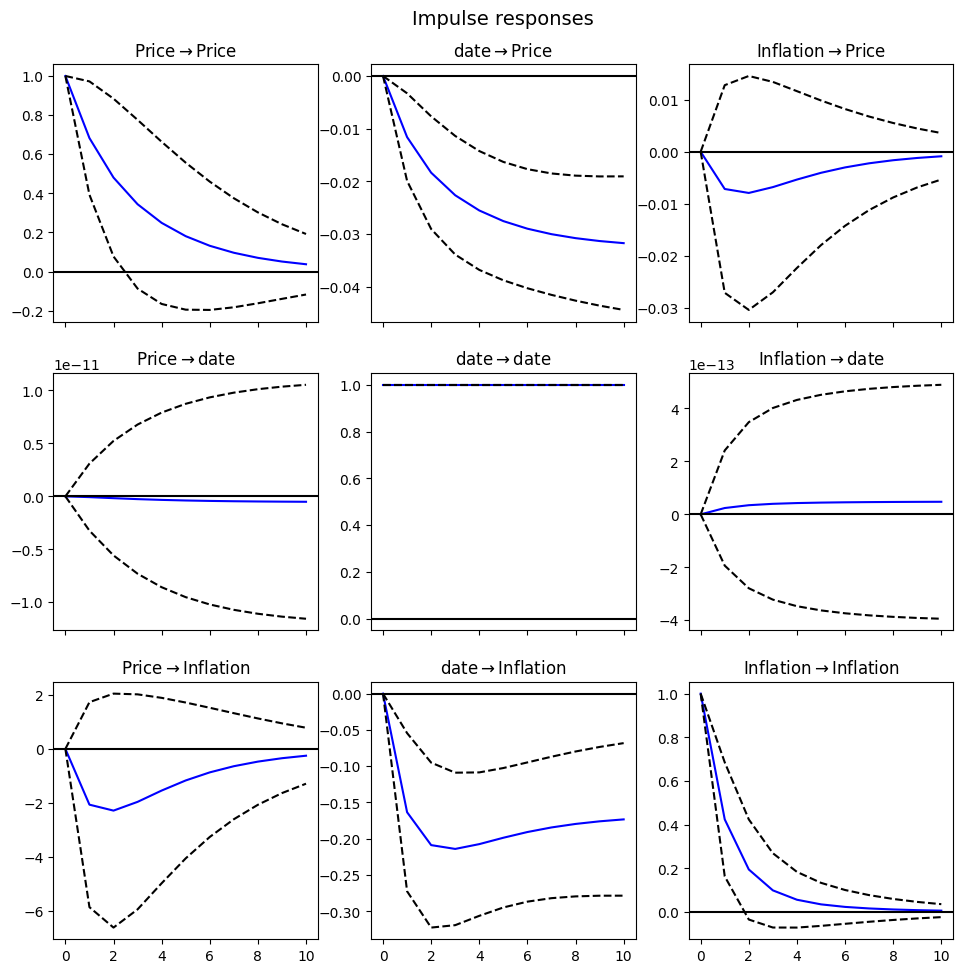

In [34]:
irf = var_model.irf(10)  # 10 periods ahead
irf.plot(orth=False)
plt.show()


                        Markov Switching Model Results                        
Dep. Variable:                  Price   No. Observations:                 9011
Model:               MarkovRegression   Log Likelihood              -35281.967
Date:                Tue, 05 Nov 2024   AIC                          70575.934
Time:                        06:13:04   BIC                          70618.571
Sample:                             0   HQIC                         70590.441
                               - 9011                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0441      0.088    227.669      0.000      19.872      20.217
sigma2        26.3180      0.704     37.394      0.0

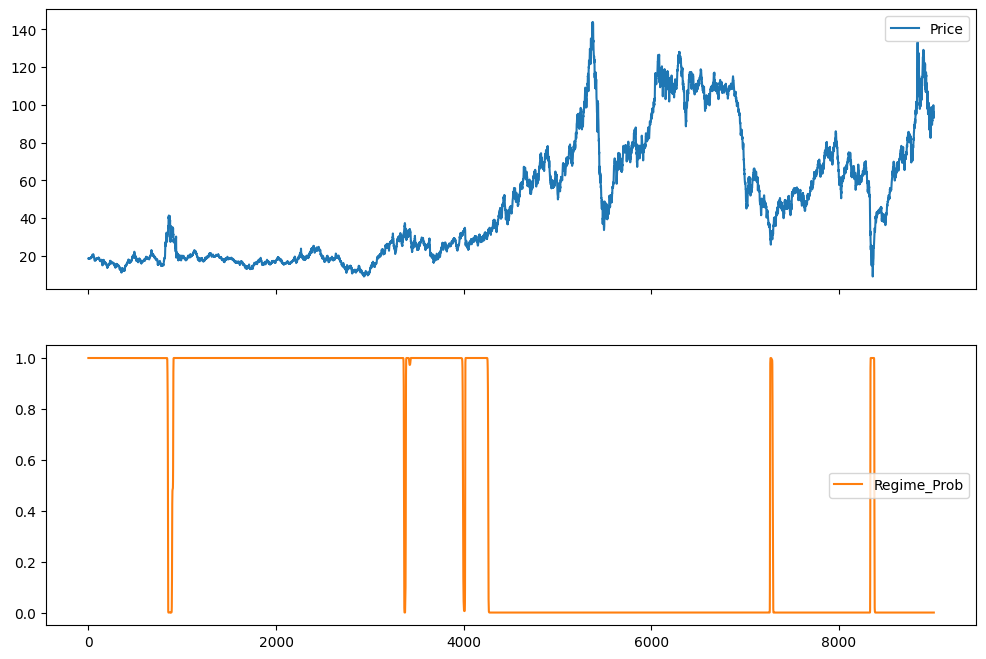

In [35]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit a Markov-Switching model
ms_model = MarkovRegression(df['Price'], k_regimes=2, trend='c', switching_variance=True).fit()
print(ms_model.summary())

# Plot the smoothed probabilities
df['Regime_Prob'] = ms_model.smoothed_marginal_probabilities[0]
df[['Price', 'Regime_Prob']].plot(subplots=True, figsize=(12, 8))
plt.show()


In [36]:
data = df['Price_Scaled'].values.reshape(-1, 1)
sequence_length = 60  # Number of days to look back
X, y = [], []

for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i, 0])
    y.append(data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=32)


In [ ]:
save_path = '/content/drive/My Drive/Brent Oil Price Analysis/data/lstm_model.h5'

# Save the model
model.save(save_path)

print(f"Model saved at {save_path}")


280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


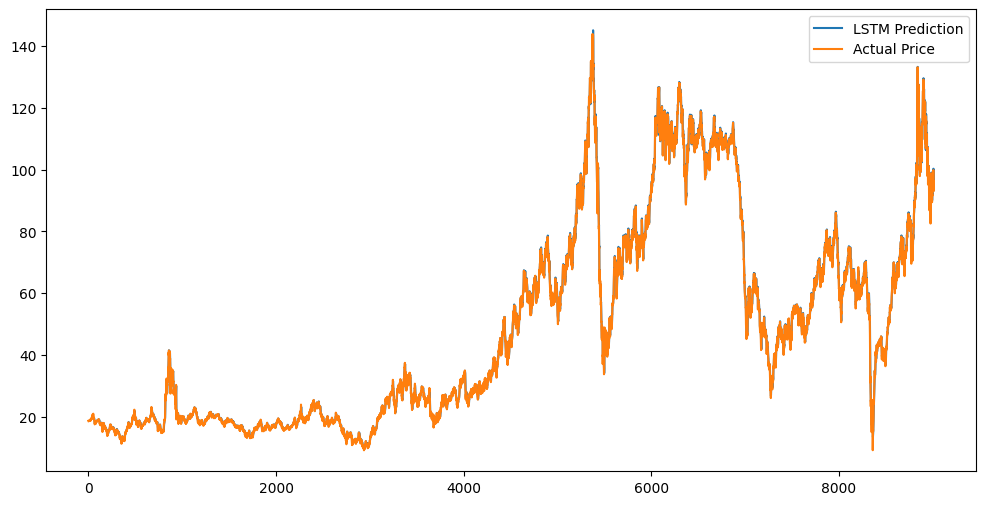

In [19]:
predictions = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(df.index[sequence_length:], scaler.inverse_transform(predictions), label='LSTM Prediction')
plt.plot(df['Price'], label='Actual Price')
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example for ARIMA
mse_arima = mean_squared_error(df['Price'][1:], df['ARIMA_Forecast'][1:])
mae_arima = mean_absolute_error(df['Price'][1:], df['ARIMA_Forecast'][1:])
r2_arima = r2_score(df['Price'][1:], df['ARIMA_Forecast'][1:])


KeyError: 'ARIMA_Forecast'